# **Deep Generative Model for spectral image synthesis**
* 2180034 - Brayan Esneider Monroy Chaparro
* 2180045 - Geison Alfredo Blanco Rodriguez
* 2180018 - Iván David Ortiz Pineda

## Contextualización del problema
Las **imágenes espectrales** contienen la información espacial y espectral de una escena. Esta información espectral resulta muy útil en áreas como, censado remoto, medicina y agricultura. 

<center><img src="https://www.spaceflightinsider.com/wp-content/uploads/2014/09/phoenix-img-2.jpg" width="50%"></center>


**Justificación del problema:**

Recientemente el Deep learning se ha incorporado entre las técnicas más prometedoras a la hora de resolver tareas de clasificación, segmentación, reconstrucción de imágenes espectrales. Sin embargo, como bien se sabe, la piedra angular del Deep learning son los datos, los cuales escasean y adicionalmente, la naturaleza de estas imágenes resulta ser de alta dimensionalidad lo cual aumenta la complejidad computacional a la hora de resolver las tareas mencionadas. 

Por consiguiente, para abordar ambas limitaciones en este trabajo se propone aprender una representación de baja dimensionalidad junto con un modelo generativo orientado a la síntesis de nuevas imágenes espectrales, permitiéndonos resolver los problemas sobre la representación de baja dimensionalidad y a su vez generar nuevos conjuntos de datos.

**Solución propuesta:**

Un enfoque tradicional para la generación de imágenes haría uso de cierta arquitectura de red GAN (generative adversal network), en donde ingresando cierto target a la red generadora esta crearía la imagen espectral correspondiente y a través del discriminador se haría la validación sobre que tan real fue la imagen generada. Así durante el entrenamiento se buscaría aumentar la capacidad del generador para sintetizar imágenes reales.

<center><img src="https://i.ibb.co/0VLnLzX/trad-1.png" width="60%"></center>

El **enfoque propuesto** en este trabajo consiste en el uso de una metodología en dos partes:
* Primero, se plantea el uso de una arquitectura de red autoencoder para aprender una representación no lineal de las imágenes espectrales, a la vez que se empleará un discriminador para aprender a diferenciar las imágenes reales y falsas con el fin de mejorar la fiabilidad del autoencoder.

<center><img src="https://i.ibb.co/tYYbPnM/architecture-1.png" width="80%"></center>

* Segundo, se plantea la implementación de un algoritmo de optimización siguiendo una arquitectura de ADMM para, con los pesos previamente entrenados, poder realizar la síntesis de imágenes espectrales partiendo de imágenes a escala de grises. En esta etapa se busca específicamente el aprendizaje de la representación de baja dimensionalidad $\alpha$ que mejor describe la imagen espectral.

<center><img src="https://i.ibb.co/TBDRc41/admm-1.png" width="60%"></center>

## Entrenamiento de la red utilizada

In [15]:
#@title **Código:** Deescarga Repositorio
!git clone https://github.com/bemc22/spectral-gans
%cd spectral-gans
! pip install -r requirements.txt
%cd ../

fatal: destination path 'spectral-gans' already exists and is not an empty directory.
/content/spectral-gans
Obtaining file:///content/spectral-gans
ERROR: Command errored out with exit status 1: python setup.py egg_info Check the logs for full command output.
/content


In [12]:
!ls

sample_data  spectral-gans  spectral_gans.egg-info


In [9]:
# ! rm -r spectral-gans

running install
running bdist_egg
running egg_info
creating spectral_gans.egg-info
writing spectral_gans.egg-info/PKG-INFO
writing dependency_links to spectral_gans.egg-info/dependency_links.txt
writing top-level names to spectral_gans.egg-info/top_level.txt
writing manifest file 'spectral_gans.egg-info/SOURCES.txt'
error: package directory 'spectral_gans' does not exist


In [ ]:
#@title **Código:** importando librerías

import tensorflow as tf
import numpy as np
from models.main import make_encoder, make_generator, make_discriminator, spectralGAN
from models.utils import discriminator_loss, autoencoder_loss, spec2rgb, get_RGB_matrix
from models.metrics import PSNR, SSIM, SAM
from data import load_dataset
import scipy.io as sio
import matplotlib.pyplot as plt

input_shape = (512,512,31)

In [ ]:
#@title **Código:** cargando el dataset

BATCH_SIZE = 3

train_params = dict(
    batch_size = BATCH_SIZE,
    shuffle = True,
    cache = True
)

test_params = dict(
    batch_size = BATCH_SIZE,
    cache = True,
    shuffle = False
)

train_ds , test_ds = load_dataset( train_params = train_params, test_params = test_params)

In [ ]:
start , stop, bands = 400, 720 , 31
RGB = get_RGB_matrix(start, stop, bands)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in power
  if __name__ == '__main__':
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


minimo -0.0008725736
maximo 1.0436529


 tf.Tensor([0.00537655 0.00534436 0.01170512], shape=(3,), dtype=float32)


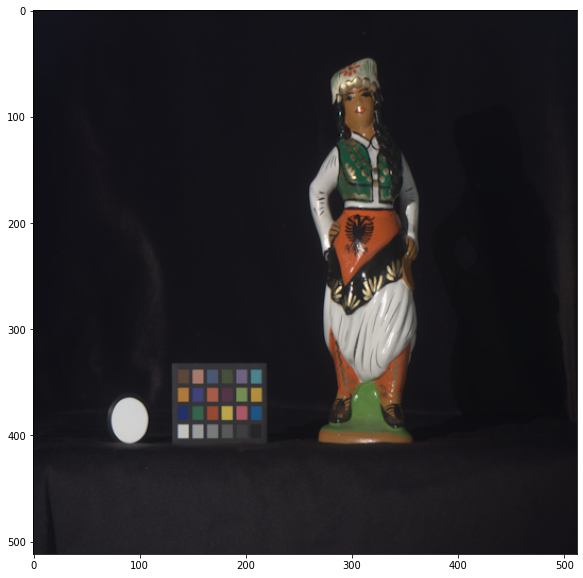

In [ ]:
sample = next(iter(train_ds))
im = np.expand_dims(sample[0,...], axis = 0)

rgb = spec2rgb(im, RGB)
print( "minimo",np.min(rgb))
print( "maximo",np.max(rgb))

plt.figure(figsize=(10,10))
plt.imshow(np.power(rgb[0,:,:,:], 0.5))
print('\n\n',rgb[0, 0,0])

In [ ]:
#@title **Código:** definiendo el optimizador y arquitectura de la red

a_optimizer = tf.keras.optimizers.Adam(1e-3)
d_optimizer = tf.keras.optimizers.Adam(1e-6)

FACTOR = [ 1/8 , 1/8 , 1/4 , 1/2 , 1/2, 1]
features= 64

encoded_shape = input_shape[:-1] + (3,)

encoder = make_encoder(encoded_shape, features=features, factors=FACTOR)
generator = make_generator(input_shape, features=features, factors=FACTOR)
discriminator = make_discriminator(input_shape)

In [ ]:
#@title **Código:** mostrando la arquitectura de las redes

encoder.summary()
generator.summary()
discriminator.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 512, 512, 3)]     0         
_________________________________________________________________
encoder (Encoder)            (None, 512, 512, 64)      23120     
Total params: 23,120
Trainable params: 23,120
Non-trainable params: 0
_________________________________________________________________
Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 512, 512, 64)]    0         
_________________________________________________________________
generator (Generator)        (None, 512, 512, 31)      24398     
Total params: 24,398
Trainable params: 24,398
Non-trainable params: 0
_________________________________________________________________
Model: "discriminator"
_________

<center><img src="https://www.researchgate.net/profile/Gozde-Unal-2/publication/323904616/figure/fig1/AS:606457334595585@1521602104652/PatchGAN-discriminator-Each-value-of-the-output-matrix-represents-the-probability-of.png" width="55%"></center>

In [ ]:
#@title **Código:** definiendo la arquitectura

from tensorflow.keras.callbacks import ModelCheckpoint

model = spectralGAN(encoder=encoder, generator=generator, discriminator=discriminator, CMF=RGB)

model.compile(
    a_optimizer = a_optimizer,
    d_optimizer = d_optimizer,
    a_loss = autoencoder_loss(tau=1e-3),
    d_loss = discriminator_loss,
    metrics = [ PSNR() , SSIM(), SAM ]
)


callbacks = [
             ModelCheckpoint( 'brayan_spectralGAN_rgb.h5', monitor='val_psnr',  verbose=1,  save_best_only=True,  save_weights_only=True,  mode="max", )
]


In [ ]:
_input = np.zeros(input_shape)[None,:]

_ = model.__call__(_input)
# model.load_weights('spectralGAN.h5')

In [ ]:
#@title **Código:** entrenando el modelo
history = model.fit(train_ds, epochs=300, validation_data=test_ds, callbacks=callbacks)

Epoch 1/300
9/9 [==============================] - 21s 1s/step - a_loss: 0.0109 - d_loss: 1.3916 - psnr: 19.8175 - ssim: 0.5543 - SAM: 49.6503 - real_acc: 0.2456 - fake_acc: 0.9391 - val_a_loss: 0.0102 - val_d_loss: 1.3868 - val_psnr: 19.7305 - val_ssim: 0.5822 - val_SAM: 47.8408 - val_real_acc: 0.4037 - val_fake_acc: 0.9426

Epoch 00001: val_psnr improved from -inf to 19.73053, saving model to brayan_spectralGAN_rgb.h5
Epoch 2/300
9/9 [==============================] - 8s 885ms/step - a_loss: 0.0078 - d_loss: 1.3899 - psnr: 20.9149 - ssim: 0.5931 - SAM: 42.7396 - real_acc: 0.2572 - fake_acc: 0.9397 - val_a_loss: 0.0083 - val_d_loss: 1.3866 - val_psnr: 20.5277 - val_ssim: 0.5910 - val_SAM: 44.0231 - val_real_acc: 0.3830 - val_fake_acc: 0.9845

Epoch 00002: val_psnr improved from 19.73053 to 20.52772, saving model to brayan_spectralGAN_rgb.h5
Epoch 3/300
9/9 [==============================] - 8s 881ms/step - a_loss: 0.0069 - d_loss: 1.3874 - psnr: 21.6812 - ssim: 0.6092 - SAM: 39.3400 -

In [ ]:
#@title **Código:** guardando los pesos
# model.save_weights('spectralGAN.h5')

In [ ]:
#@title **Código:** mostrando la arquitectura general
model.summary()

Model: "spectral_gan"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder (Functional)         (None, 512, 512, 64)      23120     
_________________________________________________________________
generator (Functional)       (None, 512, 512, 31)      24398     
_________________________________________________________________
sequential (Sequential)      (None, 512, 512, 31)      47518     
_________________________________________________________________
lambda (Lambda)              multiple                  0         
_________________________________________________________________
discriminator (Functional)   (None, 127, 127, 1)       42497     
Total params: 90,015
Trainable params: 89,759
Non-trainable params: 256
_________________________________________________________________


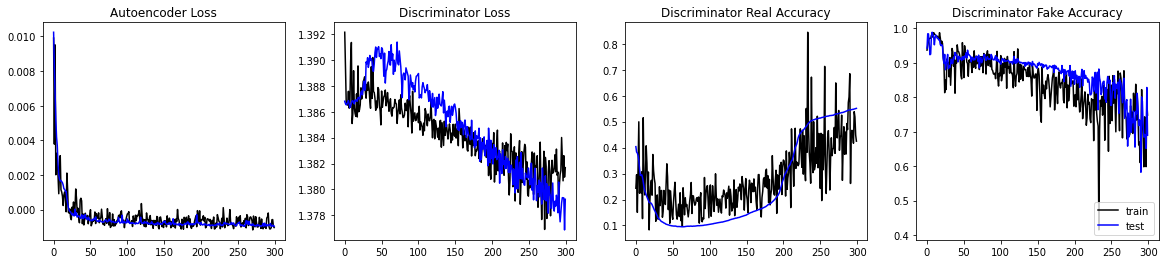

In [ ]:
#@title Training Results

fig, axs = plt.subplots(1, 4, figsize=(20,4))

axs[0].set_title("Autoencoder Loss")
axs[0].plot(history.history["a_loss"], label="train", c='k')
axs[0].plot(history.history["val_a_loss"], label="test", c='b')

axs[1].set_title("Discriminator Loss")
axs[1].plot(history.history["d_loss"], label="train", c='k')
axs[1].plot(history.history["val_d_loss"], label="test", c='b')


axs[2].set_title("Discriminator Real Accuracy")
axs[2].plot(history.history["real_acc"], label="train", c='k')
axs[2].plot(history.history["val_real_acc"], label="test", c='b')


axs[3].set_title("Discriminator Fake Accuracy")
axs[3].plot(history.history["fake_acc"], label="train", c='k')
axs[3].plot(history.history["val_fake_acc"], label="test", c='b')
axs[3].legend(loc='lower right')

plt.show()


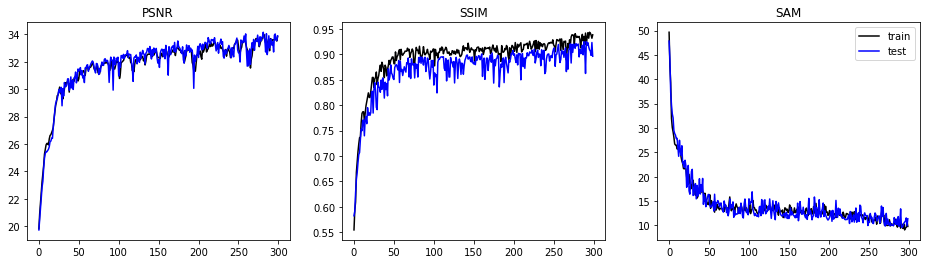

In [ ]:
#@title Metrics Results

fig, axs = plt.subplots(1, 3, figsize=(16,4))

axs[0].set_title("PSNR")
axs[0].plot(history.history["psnr"], label="train", c='k')
axs[0].plot(history.history["val_psnr"], label="test", c='b')

axs[1].set_title("SSIM")
axs[1].plot(history.history["ssim"], label="train", c='k')
axs[1].plot(history.history["val_ssim"], label="test", c='b')

axs[2].set_title("SAM")
axs[2].plot(history.history["SAM"], label="train", c='k')
axs[2].plot(history.history["val_SAM"], label="test", c='b')
axs[2].legend()

plt.show()

In [ ]:
#@title Final Results
data = []

metrics = model.evaluate(train_ds, verbose=0)[:3]
metrics = [ round(a,3) for a in metrics]
data.append(["Train"] + metrics)
metrics = model.evaluate(test_ds, verbose=0)[:3]
metrics = [ round(a,3) for a in metrics]
data.append(["Test"] + metrics)

import pandas as pd

pd = pd.DataFrame(data=data, columns=["Dataset", "PSNR","SSIM", "SAM"])
pd = pd.set_index("Dataset")

pd.head()

,PSNR,SSIM,SAM
Dataset,,,
Train,33.925,0.922,11.284
Test,33.885,0.896,11.359


In [ ]:
import cv2 

nums = 3

samples = next(iter(test_ds)).numpy()
_input = spec2rgb(samples, RGB)
generated = model.autoencoder.predict(_input)
generated_rgb = spec2rgb(generated, RGB)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


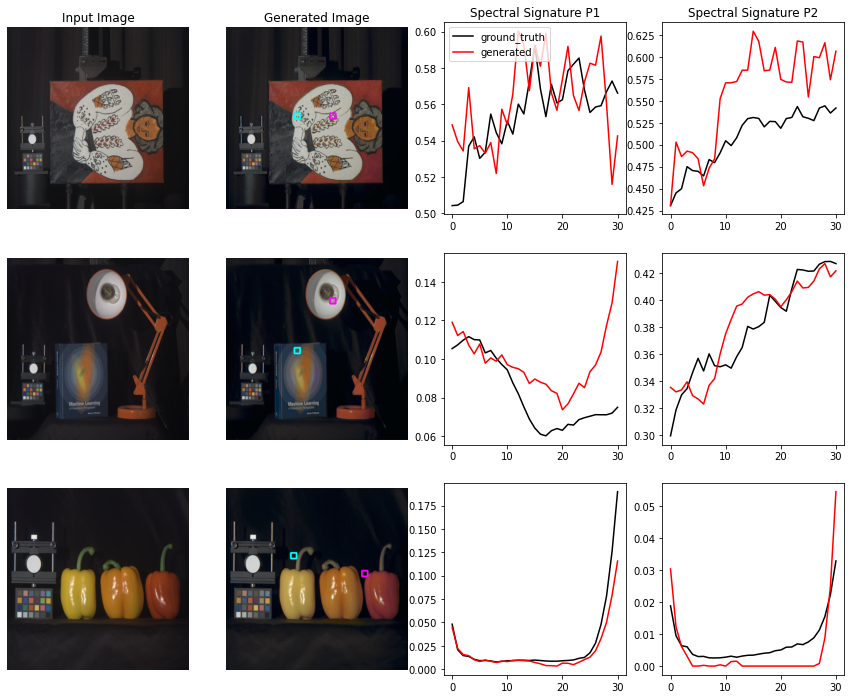

In [ ]:
#@title **Código:** mostrando imagenes generadas
fig, axs = plt.subplots(nums, 4, figsize=(15,12))

_ = [ ax.axis("off") for subax in axs for ax in subax]

axs[0,0].set_title("Input Image")
axs[0,1].set_title("Generated Image")
axs[0,2].set_title("Spectral Signature P1")
axs[0,3].set_title("Spectral Signature P2")

points = np.array([
          [200,250],
          [200,260],
          [190,190],
])

points2 = np.array([
          [300,250],
          [300,120],
          [390,240],
])

d = 8

for i in range(nums):

  point = points[i]
  point2 = points2[i]

  x_true = np.power( tf.clip_by_value(_input[i], 0 , 1), 0.5 )
  x_pred = np.power( tf.clip_by_value(generated_rgb[i], 0 , 1), 0.5 )

  x_pred = cv2.rectangle(x_pred, tuple(point - d), tuple(point + d), color=(0,255,255), thickness=3)
  x_pred = cv2.rectangle(x_pred, tuple(point2 - d), tuple(point2 + d), color=(255,0,255), thickness=3)

  axs[i,0].imshow(x_true)
  axs[i,1].imshow(x_pred)
  axs[i,2].axis("On")
  axs[i,3].axis("On")

  axs[i,2].plot( samples[i, point[1], point[0] ,:] , c='k', label="ground_truth")
  axs[i,2].plot( generated[i, point[1], point[0] ,:] , c='r', label="generated")


  axs[i,3].plot( samples[i, point2[1], point2[0] ,:] , c='k', label="ground_truth")
  axs[i,3].plot( generated[i, point2[1], point2[0] ,:] , c='r', label="generated")
  
axs[0,2].legend(loc="upper left")
plt.show()

